In [52]:
import pandas as pd
import os
import re
from textblob import TextBlob
import contractions
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet, stopwords, words
from collections import Counter
# from spellchecker import SpellChecker
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np

In [127]:
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
# nltk.download('stopwords')
#nltk.download('words')

### Important Word Set

In [143]:
STOPWORDS = set(stopwords.words('english'))
english_words = set(words.words())


def preprocess_text(text):
    text = contractions.fix(text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text.lower())  
    words = text.split()  
    words = [word for word in words if word not in STOPWORDS] 
    return words

def filter_non_standard_words(top_words):
    non_standard_words = [word for word, _ in top_words if word not in english_words]
    return non_standard_words

def word_count_in_folder(folder_path, top_k=100):
    all_words = []
    
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path)
            
            if 'title' in df.columns and 'sentence' in df.columns:
                for _, row in df.iterrows():
                    text = row['title'] + " " + row['sentence']
                    words = preprocess_text(text)
                    all_words.extend(words)  

    word_counts = Counter(all_words)
    top_words = word_counts.most_common(top_k)

    non_standard_words = filter_non_standard_words(top_words)
    
    return non_standard_words

folder_path = 'data' 
file_top_words = word_count_in_folder(folder_path, top_k=100) 
print(file_top_words)

['nt', 'ipod', 'software', 'zen', 'dvd', 'mp3', 'problems', 'features', 'players', '3', 'xtra', 'g3', 'pictures', 'christmas', '2', 'dvds', 'flaws', 'songs', 'using']


The reason we need to look at the important wordset is because this would let us assess if we should use TextBlob's `correct` function to fix the spellings within the text data. However, we have skipped correcting the spellings because these important words would also get translated and might introduce emotion into the data that did not exist before correction.

### Lowercase text data

In [347]:
def data_preprocessing(df):
    
    def selective_lowercase(text):
        return ' '.join([word if word.isupper() else word.lower() for word in text.split()])
    
    df['title'] = df['title'].apply(selective_lowercase)
    df['sentence'] = df['sentence'].apply(selective_lowercase)

    def clean_text(text):
        text = contractions.fix(text)
        # blob = TextBlob(text)
        # expanded_text = str(blob.correct())
        text = re.sub(r'\s+', ' ', text).strip()
        text = re.sub(r'[^a-zA-Z0-9\s!?-]', '', text)
        
        return text
    
    df['title'] = df['title'].apply(clean_text)
    df['sentence'] = df['sentence'].apply(clean_text)

    lemmatizer = WordNetLemmatizer()
    
    def get_wordnet_pos(nltk_pos):
        if nltk_pos.startswith('J'):
            return wordnet.ADJ
        elif nltk_pos.startswith('V'):
            return wordnet.VERB
        elif nltk_pos.startswith('N'):
            return wordnet.NOUN
        elif nltk_pos.startswith('R'):
            return wordnet.ADV
        else:
            return None

    def conditional_lemmatize(text):
        tokens = word_tokenize(text)
        pos_tags = pos_tag(tokens)
        lemmatized_text = []
        
        for token, pos in pos_tags:
            wordnet_pos = get_wordnet_pos(pos)
            if wordnet_pos in [wordnet.VERB, wordnet.NOUN]: 
                lemmatized_text.append(lemmatizer.lemmatize(token, pos=wordnet_pos))
            else:
                lemmatized_text.append(token)
        return ' '.join(lemmatized_text)
    
    df['title'] = df['title'].apply(conditional_lemmatize)
    df['sentence'] = df['sentence'].apply(conditional_lemmatize)
    
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

    # NLTK Tokenizer
    #df['title'] = df['title'].apply(word_tokenize)
    #df['sentence'] = df['sentence'].apply(word_tokenize)
    
    def tokenize_text(title, sentence):
        title_encoding = tokenizer(title, padding='max_length', truncation=True, return_tensors="pt", max_length=128)
        sentence_encoding = tokenizer(sentence, padding='max_length', truncation=True, return_tensors="pt", max_length=128)
        
        return title_encoding['input_ids'].flatten().tolist(), title_encoding['attention_mask'].flatten().tolist(), \
               sentence_encoding['input_ids'].flatten().tolist(), sentence_encoding['attention_mask'].flatten().tolist()
    
    
    df[['title_input_ids', 'title_attention_mask', 'sentence_input_ids', 'sentence_attention_mask']] = df.apply(
        lambda row: tokenize_text(row['title'], row['sentence']), axis=1, result_type='expand'
    )

    return df

In [349]:
data = {}
for _ in os.listdir():
    if _.endswith('.csv'):
        df = pd.read_csv('data/'+_)
        data[_] = data_preprocessing(df)
        data[_].to_csv('processed_data/' + _.replace('.csv', '_updated.csv'))

In [22]:
import pandas as pd
import ast
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
from transformers import BertModel, BertTokenizer, BertForSequenceClassification, AdamW, DistilBertForSequenceClassification, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm import tqdm
import warnings

file_path = "processed_data/apex_ad2600_dvd_player_updated.csv"
data = pd.read_csv(file_path)

data_features = data[['sentence_input_ids', 'sentence_attention_mask']]
data_target = data['sentiment_total']

In [24]:
sentence_input_ids = torch.tensor([eval(x) for x in data_features['sentence_input_ids']])
sentence_attention_mask = torch.tensor([eval(x) for x in data_features['sentence_attention_mask']])
sentiment_score = torch.tensor(data_target.values).float()

In [25]:
input_ids = sentence_input_ids
attention_mask = sentence_attention_mask

In [28]:
X_train, X_val, mask_train, mask_val, y_train, y_val = train_test_split(
    input_ids, attention_mask, sentiment_score, test_size=0.3, random_state=42
)

In [30]:
train_dataset = TensorDataset(X_train, mask_train, y_train)
val_dataset = TensorDataset(X_val, mask_val, y_val)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [40]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased-finetuned-sst-2-english", num_labels=1,
        ignore_mismatched_sizes = True 
    )

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([1]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    optimizer = AdamW(model.parameters(), lr=5e-5)
    num_epochs = 3
    num_training_steps = len(train_dataloader) * num_epochs
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

In [44]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

loss_fn = torch.nn.MSELoss()  # For regression tasks

for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch + 1} completed. Loss: {loss.item()}")


Epoch 1 completed. Loss: 1.4518495798110962
Epoch 2 completed. Loss: 1.1899927854537964
Epoch 3 completed. Loss: 0.6835916638374329


In [46]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = outputs.logits.squeeze(-1)
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 8. Compute metrics
mse = mean_squared_error(all_labels, all_preds)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 2.4400529861450195


In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def sign_based_accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = np.array(y_true) != 0
    y_true = np.array(y_true)[mask]
    y_pred = np.array(y_pred)[mask]
    
    y_true_sign = (y_true >0).astype(int)
    y_pred_sign = (y_pred >0).astype(int)
    correct_signs = (y_true_sign == y_pred_sign).sum()
    total = len(y_true_sign)
    cm = confusion_matrix(y_true_sign, y_pred_sign)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    return (correct_signs / total) * 100


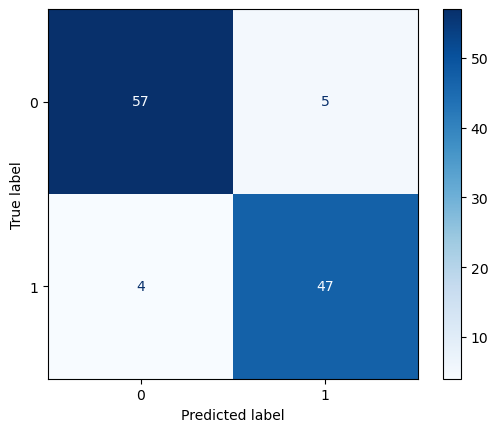

In [56]:
accuracy = sign_based_accuracy(all_labels, all_preds)

In [58]:
accuracy

92.03539823008849

In [136]:
def row_eval(test_row):
    test_inputs = torch.tensor(eval(test_row['sentence_input_ids'])).unsqueeze(0)
    test_attention = torch.tensor(eval(test_row['sentence_attention_mask'])).unsqueeze(0)
    
    model.eval()
    
    with torch.no_grad():
        outputs = model(input_ids=test_inputs, attention_mask=test_attention)
        logits = outputs.logits
    
    predicted_sentiment = (logits > 0).int().item()
    
    label_map = {0:'negative', 1:'positive'}
    
    print (f"First 50 letters of the review: \"{test_row['sentence'][:50]}\", \nSentiment Score: {test_row['sentiment_total']}")
    print (f"Predicted Sentiment Score: {int(logits[0][0])}, \nPositivity of the review: {label_map[predicted_sentiment]}")

In [138]:
test_row = data[data.sentiment_total < 0].iloc[0]
row_eval(test_row)

First 50 letters of the review: "weakness be minor the feel and layout of the remot", 
Sentiment Score: -2
Predicted Sentiment Score: -2, 
Positivity of the review: negative


In [140]:
test_row = data[data.sentiment_total > 0].iloc[1]
row_eval(test_row)

First 50 letters of the review: "but if you be look for my opinion of the apex dvd ", 
Sentiment Score: 2
Predicted Sentiment Score: 2, 
Positivity of the review: positive
